In [62]:
import pandas as pd
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import KernelPCA



from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

# Load the data from CSV files into DataFrames
zone_data_1A = pd.read_csv('zone_data_1A_clustered.csv', nrows=40000)
zone_data_7 = pd.read_csv('zone_data_7_clustered.csv')
zone_data_6 = pd.read_csv('zone_data_6_clustered.csv')

# Separate zone_data_1A into two different DataFrames based on the cluster assignment
zone_data_1A_top = zone_data_1A[zone_data_1A['Cluster'] == 0]
zone_data_1A_bottom = zone_data_1A[zone_data_1A['Cluster'] == 1]

zone_data_7_top = zone_data_7[zone_data_7['Cluster'] == 0]
zone_data_7 = zone_data_7[zone_data_7['Cluster'] == 1]

zone_data_6_top = zone_data_6[zone_data_6['Cluster'] == 1]
zone_data_6 = zone_data_6[zone_data_6['Cluster'] == 0]

# Copy the data to avoid SettingWithCopyWarning
zone_data_1A_top_sorted = zone_data_1A_top.copy()
zone_data_1A_bottom_sorted = zone_data_1A_bottom.copy()

# Copy the data for zone 6 and zone 7 to avoid SettingWithCopyWarning
zone_data_6_top_sorted = zone_data_6_top.copy()
zone_data_6_bottom_sorted = zone_data_6.copy()

zone_data_7_top_sorted = zone_data_7_top.copy()
zone_data_7_bottom_sorted = zone_data_7.copy()

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_1A_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_1A_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

# Order the data by 'Create_date_ordinal' from lowest to highest
zone_data_6_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_6_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

zone_data_7_top_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)
zone_data_7_bottom_sorted.sort_values(by='Create_date_ordinal', ascending=True, inplace=True)

print(zone_data_1A_top_sorted)




         Status Application Creation Date Approved / Refused Date  \
15192   Refused                2008-04-28              30/04/2010   
9636    Expired                2009-01-06              26/08/2009   
10589  Recorded                2009-01-10              16/10/2009   
11781  Recorded                2009-01-10              05/10/2009   
2043   Recorded                2009-01-10              09/10/2009   
...         ...                       ...                     ...   
10747  Recorded                2024-12-02              22/02/2024   
8195   Recorded                2024-12-03              16/04/2024   
16325  Recorded                2024-12-03              04/04/2024   
544    Recorded                2024-12-03              21/03/2024   
6287   Recorded                2024-12-04              16/04/2024   

      Recorded / Rejected Date Water Share ID Water System Source Reliability  \
15192               30/04/2010      WEE****03            Goulburn        High   
9636     

# Water Temperature

In [63]:
import pandas as pd
from sklearn.impute import SimpleImputer

def process_and_combine_data(file_path, merge_data=None, merge_on=('Create_date_ordinal', 'Time_ordinal'), row_thresh_multiplier=0.5):
    # Load the data
    tempData = pd.read_csv(file_path, parse_dates=['Time'], index_col='Time')
    print("Array size:", tempData.shape)
    # Drop rows where more than half the columns have missing values
    row_thresh = len(tempData.columns) * row_thresh_multiplier
    tempData = tempData.dropna(axis=0, thresh=row_thresh)
    print("Array size:", tempData.shape)
    # Drop any columns with missing values
    tempData = tempData.dropna(axis=1, how='any')
    print("Array size:", tempData.shape)

    # Group data by 'Time', calculate the mean, and reset the index
    daily_tempData = tempData.groupby(tempData.index).mean().reset_index()
    daily_tempData['Time_ordinal'] = pd.to_datetime(daily_tempData['Time']).apply(lambda x: x.toordinal())

    return daily_tempData
    # If merge data is provided, merge it on the specified columns
    if merge_data is not None and merge_on:
        combined_data = pd.merge(merge_data, daily_tempData, left_on=merge_on[0], right_on=merge_on[1], how='inner')
        # Export the combined data to a CSV file
        combined_data.to_csv('combined_data.csv', index=False)
        return combined_data

    

# Example usage:
Water_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTempData.csv'
combined_data = process_and_combine_data(Water_temp_file_path, merge_data=zone_data_1A_top_sorted)

# Export the combined data to a CSV file
combined_data.to_csv('combined_data.csv', index=False)

Array size: (10227, 402)
Array size: (4281, 402)
Array size: (4281, 7)


# Trade off between spacial and temporal patterns

Temporal Trends: If the focus is on understanding how patterns evolve over time or capturing seasonal variations and long-term trends, having a longer time period with data from fewer stations might be more beneficial.
Spatial Patterns: If the goal is to compare spatial variations or the behavior across different locations, then analyzing more stations over a shorter period might provide more insights into spatial differences.

In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf)


['226227', '235211', '409002', '409014', '409023', '409036', '409061']
Explained Variance Ratio: [0.86282439 0.11217535]
      principal component 1  principal component 2 Create_date
0                  4.119903              -1.645197  2010-01-02
1                  4.255044              -1.672265  2010-01-09
2                  4.255044              -1.672265  2010-01-09
3                  4.255044              -1.672265  2010-01-09
4                  4.255044              -1.672265  2010-01-09
...                     ...                    ...         ...
7958               3.321621               1.945406  2023-12-22
7959               3.321621               1.945406  2023-12-22
7960               3.321621               1.945406  2023-12-22
7961               3.321621               1.945406  2023-12-22
7962               3.321621               1.945406  2023-12-22

[7963 rows x 3 columns]


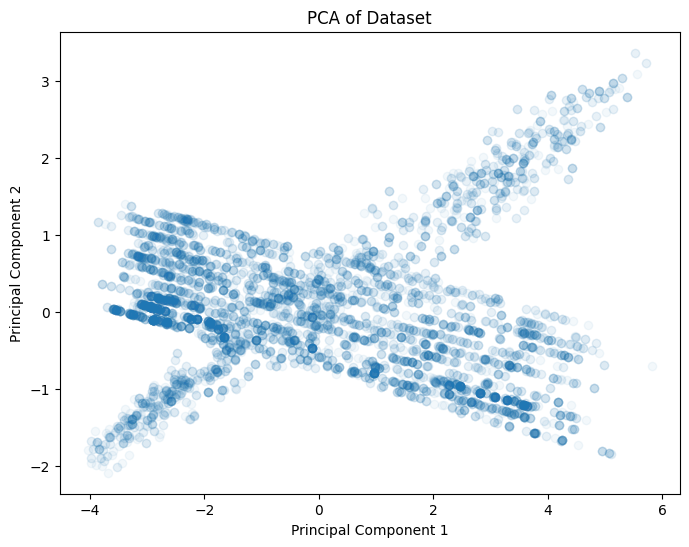

Explained Variance Ratio: [0.86282439 0.11217535]
      principal component 1  principal component 2 Create_date
0                  4.119903              -1.645197  2010-01-02
1                  4.255044              -1.672265  2010-01-09
2                  4.255044              -1.672265  2010-01-09
3                  4.255044              -1.672265  2010-01-09
4                  4.255044              -1.672265  2010-01-09
...                     ...                    ...         ...
7958               3.321621               1.945406  2023-12-22
7959               3.321621               1.945406  2023-12-22
7960               3.321621               1.945406  2023-12-22
7961               3.321621               1.945406  2023-12-22
7962               3.321621               1.945406  2023-12-22

[7963 rows x 3 columns]


In [65]:
# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf)

# Turbidity

In [77]:
# Example usage:
Turbidity_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanTurbidity.csv'
combined_data = process_and_combine_data(Turbidity_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.56)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf)

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf)

Array size: (5114, 118)
Array size: (303, 118)
Array size: (303, 29)
['221224', '222201', '224217', '225209', '226017', '226027', '226227', '232204', '232210', '233217', '234201', '237205', '238206', '401549', '403241', '404216', '405240', '405257', '41001701', '41001702', '410134', '410729', '410733', '410747', '410761', '410774', '410777', '410781', '415608']
Explained Variance Ratio: [0.17750039 0.10966792]


KeyError: "None of [Index(['Create_date'], dtype='object')] are in the [columns]"

# Dry Air

Array size: (7007, 14)
Array size: (811, 14)
Array size: (811, 6)
['219027', '410102', '570818', '570825', '570947', 'ST514A']
Explained Variance Ratio: [0.62699249 0.15464032]
      principal component 1  principal component 2 Create_date
0                 -1.973728              -0.614708  2012-08-13
1                 -1.973728              -0.614708  2012-08-13
2                 -1.973728              -0.614708  2012-08-13
3                 -1.973728              -0.614708  2012-08-13
4                 -1.445265              -0.130234  2012-08-14
...                     ...                    ...         ...
1515              -0.788001               0.097530  2015-10-09
1516              -1.274594              -0.567470  2015-10-11
1517              -1.274594              -0.567470  2015-10-11
1518              -1.274594              -0.567470  2015-10-11
1519              -1.274594              -0.567470  2015-10-11

[1520 rows x 3 columns]


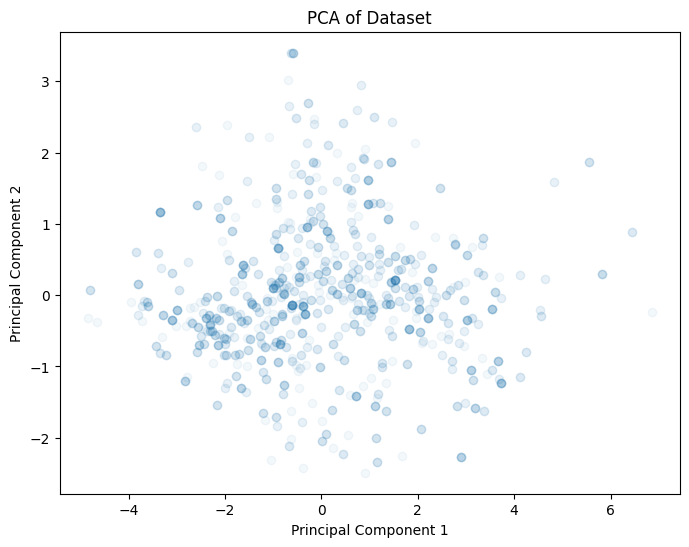

Explained Variance Ratio: [0.62699249 0.15464032]
   principal component 1  principal component 2 Create_date
0              -1.973728              -0.614708  2012-08-13
1              -1.973728              -0.614708  2012-08-13
2              -1.973728              -0.614708  2012-08-13
3              -1.973728              -0.614708  2012-08-13
4              -1.445265              -0.130234  2012-08-14


In [67]:
# Example usage:
DryAir_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanDryAir.csv'
combined_data = process_and_combine_data(DryAir_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.6)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf)

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf.head())

# EC

Array size: (10227, 311)
Array size: (3465, 311)
Array size: (3465, 7)
['234200', '409002', '409023', '409061', '409062', '409086', '410781']
Explained Variance Ratio: [0.2764975  0.18809513]
   principal component 1  principal component 2 Create_date
0              -0.101752              -0.544266  2010-03-05
1              -0.030158              -0.534251  2010-03-08
2              -0.030158              -0.534251  2010-03-08
3              -0.030158              -0.534251  2010-03-08
4              -0.030158              -0.534251  2010-03-08


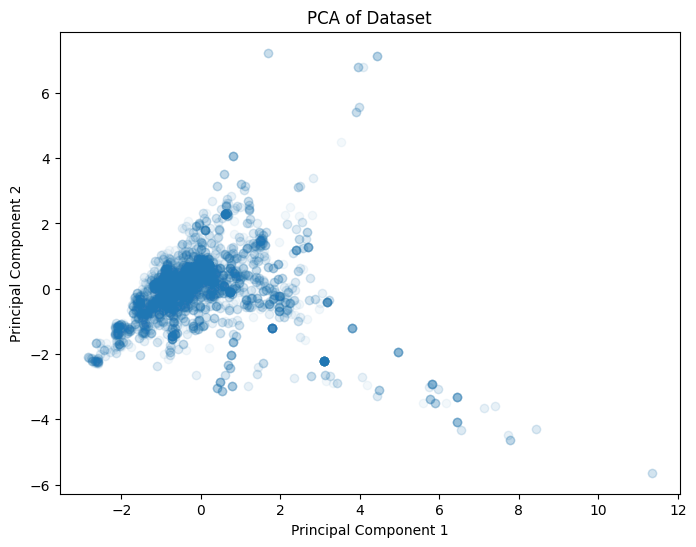

Explained Variance Ratio: [0.2764975  0.18809513]
   principal component 1  principal component 2 Create_date
0              -0.101752              -0.544266  2010-03-05
1              -0.030158              -0.534251  2010-03-08
2              -0.030158              -0.534251  2010-03-08
3              -0.030158              -0.534251  2010-03-08
4              -0.030158              -0.534251  2010-03-08


In [68]:
# Example usage:
EC_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyEC.csv'
combined_data = process_and_combine_data(EC_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.6)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf.head())

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf.head())

# RainFall

In [76]:
# Example usage:
Rainfall_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyRainfall.csv'
combined_data = process_and_combine_data(Rainfall_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf)

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf.head())

Array size: (14001, 725)
Array size: (5114, 725)
Array size: (5114, 27)
['00009', '215014', '225201', '225218', '226216', '226415', '231211', '233803', '234201', '237207', '403805', '410535', '570801', '570813', '570967', '570991', 'sp-o10109', 'sp-o10138', 'sp-o10350', 'sp-o10438', 'sp-o10606', 'sp-o10814', 'sp-o10926', 'sp-o10930', 'sp-o11430', 'sp-o11454', 'sp-o11590']
Explained Variance Ratio: [0.34056559 0.1155597 ]


KeyError: "None of [Index(['Create_date'], dtype='object')] are in the [columns]"

# WaterCourse

Array size: (14000, 1360)
Array size: (5114, 1360)
Array size: (5114, 216)
['2122711', '215002', '215007', '215014', '215208', '215239', '217006', '218001', '218005', '218007', '219003', '219017', '219022', '219025', '219032', '220003', '220004', '221201', '221208', '221209', '221210', '221212', '221224', '222007', '222008', '222017', '222019', '222200', '222202', '222206', '222219', '222522', '222541', '223202', '223204', '223205', '223214', '224201', '224203', '224217', '225201', '225209', '225212', '225218', '225219', '225231', '225232', '226007', '226023', '226209', '226224', '226228', '226402', '227202', '227211', '227213', '227219', '227226', '227237', '228203C', '228204C', '228209B', '228212A', '228217C', '228225A', '228228A', '228229B', '228231A', '228235A', '228351B', '228356B', '228357A', '228362A', '228368A', '228380A', '228382A', '228393A', '229109A', '229135A', '229144A', '229149A', '229200B', '229206A', '229212A', '229249A', '229257A', '229270A', '229272A', '229403A', '22

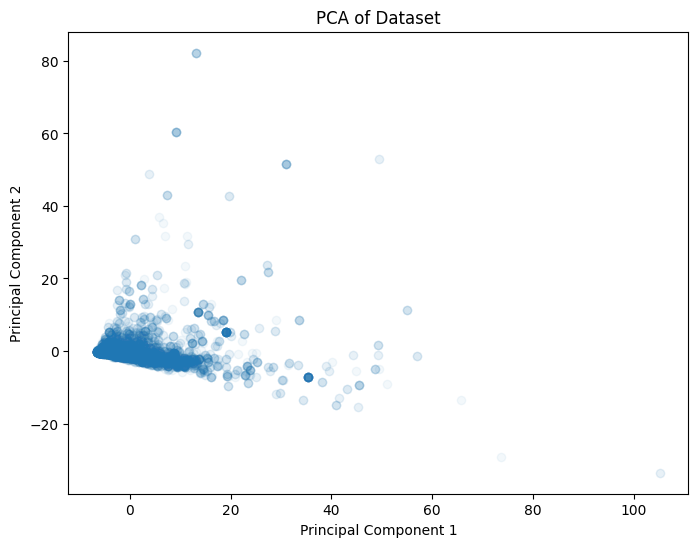

Explained Variance Ratio: [0.2753523  0.10836875]
   principal component 1  principal component 2 Create_date
0              -2.397140              -1.419098  2010-01-02
1              -5.921108              -0.403344  2010-01-09
2              -5.921108              -0.403344  2010-01-09
3              -5.921108              -0.403344  2010-01-09
4              -5.921108              -0.403344  2010-01-09


In [70]:
# Example usage:
WaterCourse_temp_file_path = '../GET_WATER_DATA_ONLINE/DailyMeanWaterCourseDischarge.csv'
combined_data = process_and_combine_data(WaterCourse_temp_file_path, merge_data=zone_data_1A_top_sorted, row_thresh_multiplier=0.5)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer


# Now apply PCA
pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(combined_data)



# Standardize columns 53 to 56 excluding specified columns
columns_to_exclude = ['Status', 'Application Creation Date', 'Approved / Refused Date', 'Recorded / Rejected Date', 'Water Share ID', 'Water System Source', 'Reliability', 'Trading Zone Source', 'Seller Water Authority', 'Seller Trading Zone Use', 'Buyer Water Authority', 'Buyer Trading Zone Use', 'Create_date', 'Create_date_ordinal', 'Cluster', 'Time', 'Time_ordinal', 'Price Per ML ($)', 'Volume Traded (ML)']
columns_to_standardize = [col for col in combined_data.columns[1:] if col not in columns_to_exclude]


x = StandardScaler().fit_transform(combined_data[columns_to_standardize].values)

print(columns_to_standardize)

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Combine with original data
finalDf = pd.concat([principalDf, combined_data[['Create_date']]], axis=1)

# Display the results of the PCA
print(finalDf.head())

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(finalDf['principal component 1'], finalDf['principal component 2'], alpha=0.05)
plt.title('PCA of Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Display the top rows of the final DataFrame
print(finalDf.head())

# SARIMA

In [71]:
from statsmodels.tsa.stattools import adfuller

# Function to test stationarity
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Assuming 'principal component 1' as the target series
test_stationarity(finalDf['principal component 1'])


ADF Statistic: -6.565494
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.40409D+00    |proj g|=  2.43391D-01

At iterate    5    f=  2.34658D+00    |proj g|=  2.84713D-04

At iterate   10    f=  2.34657D+00    |proj g|=  3.21330D-04

At iterate   15    f=  2.34656D+00    |proj g|=  2.00447D-03

At iterate   20    f=  2.34644D+00    |proj g|=  4.10291D-03

At iterate   25    f=  2.34629D+00    |proj g|=  3.84953D-04

At iterate   30    f=  2.34629D+00    |proj g|=  1.24875D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

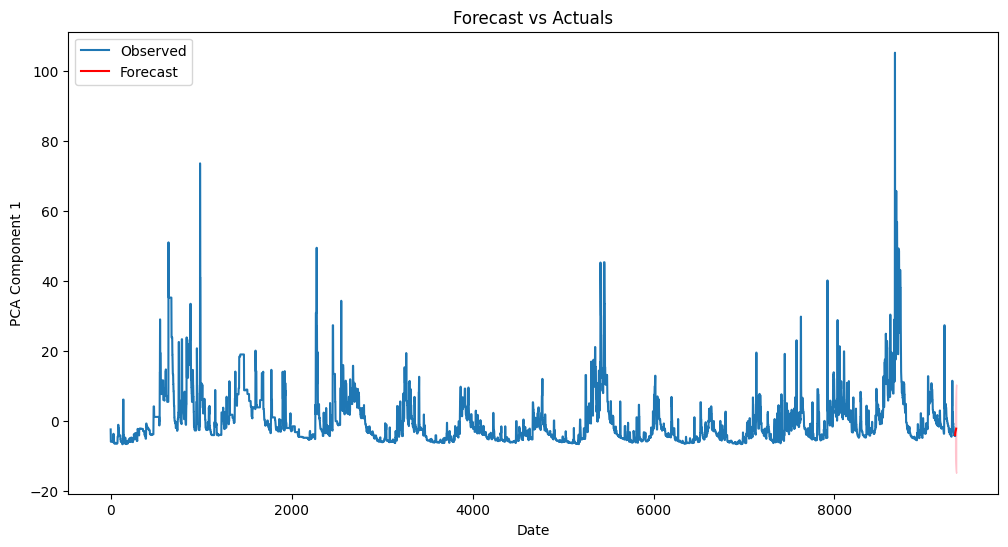

In [72]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Assuming 'finalDf' and 'principal component 1' are already defined and correct

# Fit the SARIMAX model
model = sm.tsa.statespace.SARIMAX(finalDf['principal component 1'],
                                  order=(1, 0, 1),              # Adjust these based on your model selection
                                  seasonal_order=(1, 0, 1, 12)) # Adjust these based on your model selection
results = model.fit()

# Get forecast of next 12 periods with confidence intervals
forecast = results.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

# Plotting
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(finalDf.index, finalDf['principal component 1'], label='Observed')



# Plot forecasted values
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='r', label='Forecast')

# Plot the confidence intervals
plt.fill_between(forecast.predicted_mean.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.9)

plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('PCA Component 1')
plt.legend()
plt.show()


In [73]:
print(combined_data)



        Status Application Creation Date Approved / Refused Date  \
0     Recorded                2010-01-02              10/02/2010   
1      Refused                2010-01-09              02/09/2010   
2      Refused                2010-01-09              02/09/2010   
3      Refused                2010-01-09              01/09/2010   
4      Refused                2010-01-09              01/09/2010   
...        ...                       ...                     ...   
9329  Recorded                2023-12-22              10/01/2024   
9330  Recorded                2023-12-22              10/01/2024   
9331  Recorded                2023-12-22              22/12/2023   
9332   Refused                2023-12-22              26/04/2024   
9333  Recorded                2023-12-22              10/01/2024   

     Recorded / Rejected Date Water Share ID Water System Source Reliability  \
0                  12/03/2010      WEE****55            Goulburn        High   
1                  02/0

In [74]:
# Imports
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasRegressor
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error



/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07793D+00    |proj g|=  2.74602D-02


 This problem is unconstrained.



At iterate    5    f=  7.07463D+00    |proj g|=  1.98808D-02

At iterate   10    f=  7.07348D+00    |proj g|=  5.71141D-03

At iterate   15    f=  7.07231D+00    |proj g|=  1.30216D-02

At iterate   20    f=  7.07177D+00    |proj g|=  6.77761D-03

At iterate   25    f=  7.07165D+00    |proj g|=  1.41137D-03

At iterate   30    f=  7.07162D+00    |proj g|=  2.15360D-03

At iterate   35    f=  7.07158D+00    |proj g|=  1.59840D-03

At iterate   40    f=  7.07157D+00    |proj g|=  4.83574D-04

At iterate   45    f=  7.07157D+00    |proj g|=  1.52799D-03


/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.07157D+00    |proj g|=  1.59520D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     58      1     0     0   1.595D-03   7.072D+00
  F =   7.0715688910667591     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/almazkhalilov/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


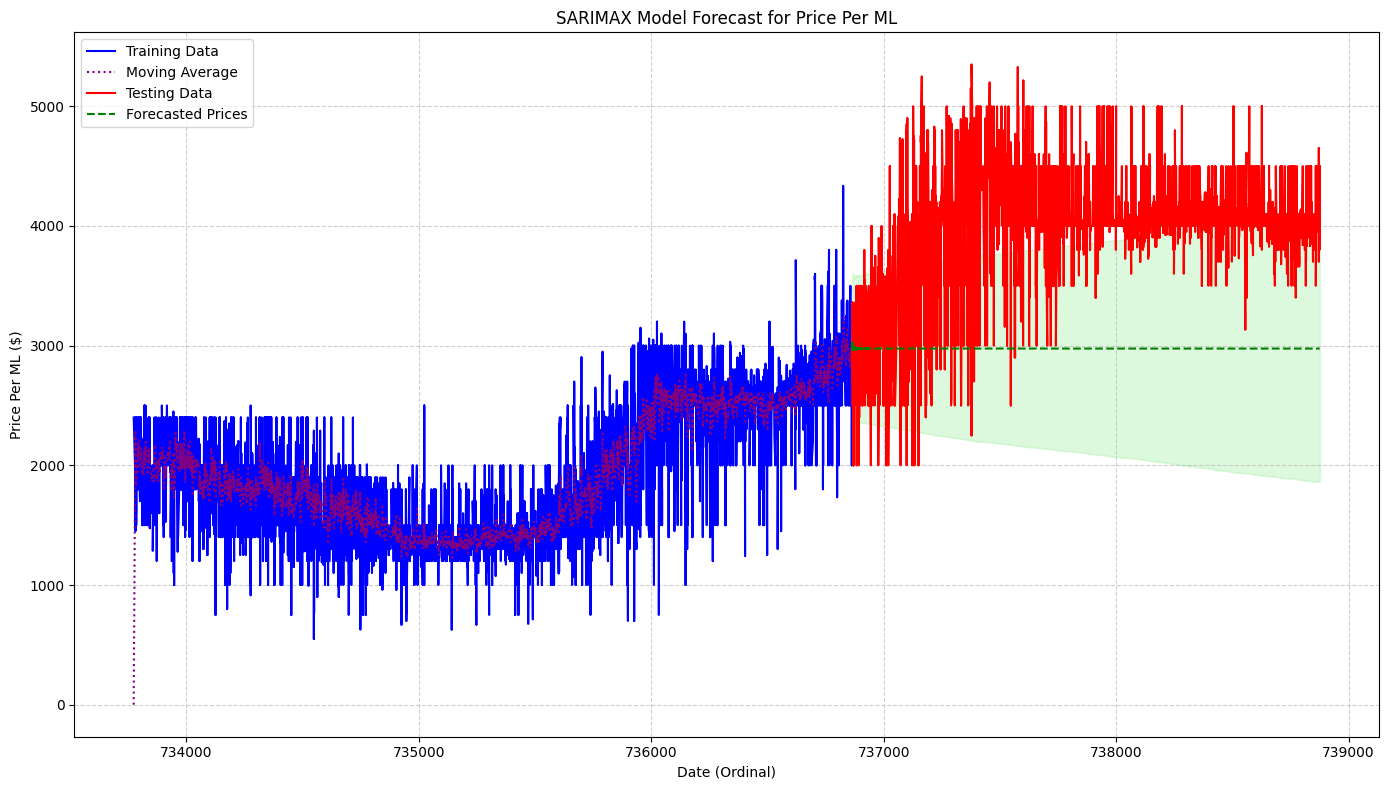

Confidence intervals generated successfully.
Model Summary:
                                       SARIMAX Results                                        
Dep. Variable:                       Price Per ML ($)   No. Observations:                 6533
Model:             SARIMAX(10, 1, 10)x(1, 0, [1], 12)   Log Likelihood              -46198.560
Date:                                Mon, 13 May 2024   AIC                          92443.119
Time:                                        23:58:23   BIC                          92599.162
Sample:                                             0   HQIC                         92497.076
                                               - 6533                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7128 

In [75]:
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt


def build_sarimax_model(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    fitted_model = model.fit()
    return fitted_model

def forecast_and_simulate(model, steps=1000):
    # Get the forecast result
    forecast_result = model.get_forecast(steps=steps)
    forecast_mean = forecast_result.predicted_mean
    # Convert MultiIndex DataFrame to standard column format
    conf_intervals = forecast_result.conf_int()
    conf_intervals.columns = ['lower', 'upper']
    return forecast_mean, conf_intervals

# Assuming the 'Price Per ML ($)' column contains the data of interest
series_data = combined_data.set_index('Create_date_ordinal')['Price Per ML ($)']

# Split data into training and testing sets using train_test_split
# Note: shuffle=False is crucial for time series data to maintain the temporal order
train_data, test_data = train_test_split(series_data, test_size=0.3, shuffle=False)

# Build ARMA model on training data
sarimax_model = build_sarimax_model(train_data, order=(10, 1, 10), seasonal_order=(1, 0, 1, 12))

# Simulate future prices on test data
forecast_series, conf_df = forecast_and_simulate(sarimax_model, steps=len(test_data))

# Visualization
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_data.index, train_data, label="Training Data", color='blue')

# Plot moving average line using fitted values
plt.plot(train_data.index, sarimax_model.fittedvalues, label="Moving Average", color='purple', linestyle=':')


# Plot testing data
plt.plot(test_data.index, test_data, label="Testing Data", color='red')

# Plot forecasted data
plt.plot(test_data.index, forecast_series, label="Forecasted Prices", linestyle='--', color='green')

# Fill between for confidence intervals
plt.fill_between(test_data.index, conf_df['lower'], conf_df['upper'], alpha=0.3, color='lightgreen')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.6)

# Add labels and legend
plt.xlabel("Date (Ordinal)")
plt.ylabel("Price Per ML ($)")
plt.legend()

# Title and show plot
plt.title("SARIMAX Model Forecast for Price Per ML")
plt.tight_layout()
plt.show()

# Validate model parameters and convergence
if not sarimax_model.mle_retvals['converged']:
    print("Warning: Model did not converge. Check model parameters and data.")
else:
    print("Model converged successfully.")


# Validate forecast intervals
if conf_df['lower'].isnull().any() or conf_df['upper'].isnull().any():
    print("Warning: Confidence intervals contain null values. Check forecast outputs.")
else:
    print("Confidence intervals generated successfully.")
# Display model fit summary
print("Model Summary:")
print(sarimax_model.summary())

# Calculate and display error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate errors on the test data
mse = mean_squared_error(test_data, forecast_series)
mae = mean_absolute_error(test_data, forecast_series)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

from sklearn.metrics import r2_score
r_squared = r2_score(test_data, forecast_series)
print("R-squared:", r_squared)
